In [1]:
import geopandas as gpd
df = gpd.read_file('/data/acker/ALA/paper2/all_variables.shp')
df = df.rename(columns={'monitor__1':'monitor_coverage_pct', 'classifica':'classification', 'Design Val':'Design Value', 'monitor_co':'monitor_count',
                        'fire_regio':'fire_region', 'mountain_r':'mountain_region', 'desert_reg':'desert_region', 'urban_cate':'urban_category'})
#upload shapefile of U.S. counties
counties = gpd.read_file('/data/acker/shapefiles/cb_2020_us_county_500k.shp')
# List of state abbreviations for CONUS, Alaska (AK), and Hawaii (HI)
states_to_include = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'DC',
    'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS',
    'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
    'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV',
    'WI', 'WY'
]

# Filter counties to only include rows where STUSPS is in the specified list
counties_conus = counties[counties['STUSPS'].isin(states_to_include)]

# Display the filtered counties
counties_conus = counties_conus.drop(["COUNTYNS", 'NAMELSAD', 'LSAD', 'ALAND', 'AWATER', 'AFFGEOID'], axis=1)
counties_conus = counties_conus.to_crs(df.crs)
df = df.drop(columns='geometry')


# Merge with both GEOID and geometry
new = df.merge(counties_conus[['GEOID', 'geometry']], on='GEOID', how='inner')

# Recast as GeoDataFrame
ranked_correct = gpd.GeoDataFrame(new, geometry='geometry', crs=counties_conus.crs)
df = ranked_correct

In [2]:
import numpy as np

df["monitor_bin"] = np.where(df["monitor_count"] <= 2, "<=2 monitors", ">2 monitors")
df["monitor_coverage_category"] = np.where(
    (df["monitor_coverage_pct"] < 0.05) | (df["monitor_coverage_pct"] > 0.1),
    "High risk (<0.05 or >0.1)",
    "Low risk (0.05–0.1)"
)
df['CDV_binned'] = np.where(
    (df["cdv_bin"] == '<7') | (df["cdv_bin"] == '>10'),
    "High risk (< 7 or > 10)",
    "Low risk (7–10)"
)

In [3]:
df['monitor_coverage_pct'].describe()

count    536.000000
mean       0.102089
std        0.176742
min        0.000000
25%        0.035047
50%        0.058360
75%        0.089646
max        1.746725
Name: monitor_coverage_pct, dtype: float64

In [4]:
low = df[df['monitor_coverage_category'] == "Low risk (0.05–0.1)"]
low.describe()

,PM25_90th,Design Value,diff,abs_diff,monitor_count,monitor_coverage_pct,dist_km
count,194.000000,194.000000,194.000000,1.940000e+02,194.000000,194.000000,194.000000
mean,8.218505,8.020619,0.197887,6.921822e-01,1.268041,0.071235,20.442241
std,1.068752,1.260762,0.888678,5.895017e-01,0.910679,0.013282,12.134348
min,3.633333,4.400000,-2.733334,9.536743e-08,1.000000,0.050050,2.266747
25%,7.654166,7.300000,-0.233334,2.333336e-01,1.000000,0.059462,11.029440
50%,8.300000,8.100000,0.183333,5.333333e-01,1.000000,0.069257,18.605019
75%,8.791667,8.700000,0.766667,9.916665e-01,1.000000,0.082696,27.210112
max,12.533333,14.100000,2.666667,2.733334e+00,10.000000,0.099206,81.864071


In [5]:
high = df[df['monitor_coverage_pct'] > 0.1]
len(high)

114

In [6]:
high.describe()

,PM25_90th,Design Value,diff,abs_diff,monitor_count,monitor_coverage_pct,dist_km
count,114.000000,114.000000,114.000000,1.140000e+02,114.000000,114.000000,113.000000
mean,8.696930,8.478070,0.218860,7.758188e-01,2.333333,0.302964,37.184681
std,1.077727,1.497003,0.961254,6.042438e-01,1.807882,0.306167,205.815613
min,3.100000,3.700000,-2.366667,1.907349e-07,1.000000,0.100604,0.892131
25%,8.141667,7.600000,-0.516667,3.441665e-01,1.000000,0.130506,8.766569
50%,8.816667,8.450000,0.283333,6.300000e-01,2.000000,0.194001,14.618431
75%,9.384167,9.400000,0.825000,1.025000e+00,3.000000,0.356676,25.676780
max,10.766666,13.000000,2.400000,2.400000e+00,11.000000,1.746725,2201.938662


In [7]:
# check dist_km for top 5 counties

In [7]:
high.columns

Index(['GEOID', 'PM25_90th', 'Design Value', 'classification', 'diff',
       'abs_diff', 'monitor_count', 'cdv_bin', 'monitor_coverage_pct',
       'dist_km', 'size', 'fire_region', 'mountain_region', 'desert_region',
       'urban_category', 'geometry', 'monitor_bin',
       'monitor_coverage_category', 'CDV_binned'],
      dtype='object')

In [8]:
len(high[high['cdv_bin'] == '>10'])

13

In [9]:
len(high[high['Design Value'] > 9])

38

In [10]:
high_pollution = high[high['Design Value'] > 9]
high_pollution.describe()

,PM25_90th,Design Value,diff,abs_diff,monitor_count,monitor_coverage_pct,dist_km
count,38.000000,38.000000,38.000000,3.800000e+01,38.000000,38.000000,38.000000
mean,9.497895,10.047368,-0.549474,6.915791e-01,3.552632,0.293424,18.770876
std,0.651137,1.012553,0.721817,5.830033e-01,2.321432,0.238074,10.243762
min,7.966667,9.100000,-2.366667,1.907349e-07,1.000000,0.100604,0.892131
25%,8.987500,9.400000,-0.883334,3.083338e-01,2.000000,0.158378,10.986168
50%,9.400001,9.650000,-0.541667,5.833334e-01,3.000000,0.204813,17.629255
75%,9.816666,10.100000,-0.033334,9.000006e-01,5.000000,0.367091,25.801312
max,10.766666,13.000000,0.900001,2.366667e+00,11.000000,1.369863,48.002319


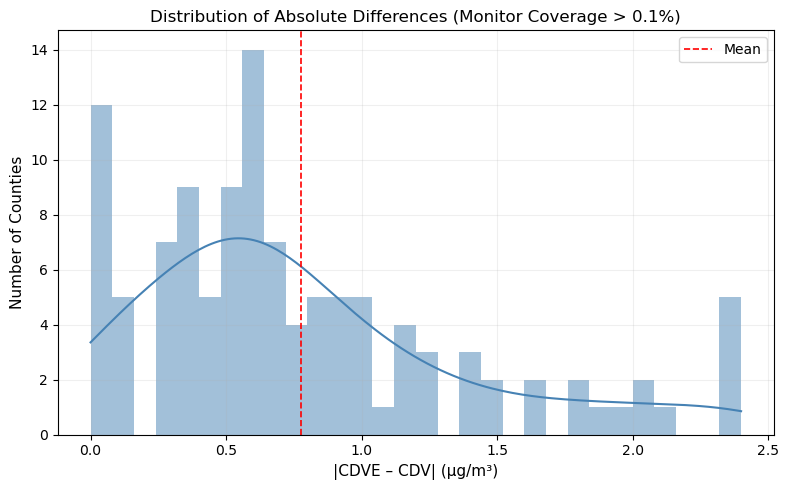

In [11]:
#plot distribution of differences, maybe there are just a few random counties that are driving this up
import matplotlib.pyplot as plt
import seaborn as sns


# Plot histogram + kernel density estimate
plt.figure(figsize=(8,5))
sns.histplot(high["abs_diff"], bins=30, kde=True, color="steelblue", edgecolor=None)

plt.axvline(high["abs_diff"].mean(), color="red", linestyle="--", linewidth=1.2, label="Mean")
plt.xlabel("|CDVE – CDV| (µg/m³)", fontsize=11)
plt.ylabel("Number of Counties", fontsize=11)
plt.title("Distribution of Absolute Differences (Monitor Coverage > 0.1%)", fontsize=12)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [13]:
# this plot has a long tail, meaning that there are a few counties that are outliers that are contributing large differences
#can see that the peak number of counties is around 0.6, a much smaller abs mean difference value

In [12]:
# identify the outliers using IQR
Q1 = high["abs_diff"].quantile(0.25)
Q3 = high["abs_diff"].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

outliers_iqr = high[(high["abs_diff"] > upper_bound) | (high["abs_diff"] < lower_bound)]
print(outliers_iqr[["GEOID", "abs_diff"]])


     GEOID  abs_diff
19   26163  2.346666
35   22051  2.333333
38   39035  2.366667
78   12103  2.400000
170  12117  2.099999
284  24029  2.066667
388  44003  2.366666


In [15]:
high_no_outliers = high[~high['GEOID'].isin(outliers_iqr['GEOID'])]
mean_no_outliers = high_no_outliers['abs_diff'].mean()
print(mean_no_outliers)


0.6772275242850047


In [15]:
#look at outlier difference causing counties and see if max monitor is close to a high emitting thing
#look at dist_km

In [16]:
outliers_iqr

,GEOID,PM25_90th,Design Value,classification,diff,abs_diff,monitor_count,cdv_bin,monitor_coverage_pct,dist_km,size,fire_region,mountain_region,desert_region,urban_category,geometry,monitor_bin,monitor_coverage_category,CDV_binned
19,26163,10.653334,13.0,TP,-2.346666,2.346666,8,>10,0.421941,31.701950,small,Non-Fire,Non-Mountain,Non-Desert,Urban (≥50%),"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",>2 monitors,High risk (<0.05 or >0.1),High risk (< 7 or > 10)
35,22051,10.033333,7.7,FP,2.333333,2.333333,2,7–10,0.290416,10.681106,small,Non-Fire,Non-Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-89.95023 29.27704, -89.94302 ...",<=2 monitors,High risk (<0.05 or >0.1),Low risk (7–10)
38,39035,9.833333,12.2,TP,-2.366667,2.366667,5,>10,0.363901,18.071058,small,Non-Fire,Non-Mountain,Non-Desert,Urban (≥50%),"POLYGON ((-81.97116 41.35306, -81.97096 41.369...",>2 monitors,High risk (<0.05 or >0.1),High risk (< 7 or > 10)
78,12103,9.300000,6.9,FP,2.400000,2.400000,2,<7,0.231750,10.654370,small,Non-Fire,Non-Mountain,Non-Desert,Urban (≥50%),"MULTIPOLYGON (((-82.69547 27.66549, -82.69391 ...",<=2 monitors,High risk (<0.05 or >0.1),High risk (< 7 or > 10)
170,12117,8.599999,6.5,TN,2.099999,2.099999,1,<7,0.109890,23.667701,small,Non-Fire,Non-Mountain,Non-Desert,Urban (≥50%),"POLYGON ((-81.45969 28.64436, -81.4597 28.6446...",<=2 monitors,High risk (<0.05 or >0.1),High risk (< 7 or > 10)
284,24029,8.066667,6.0,TN,2.066667,2.066667,1,<7,0.111607,26.388860,small,Non-Fire,Non-Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-76.27737 39.15165, -76.27464 39.165...",<=2 monitors,High risk (<0.05 or >0.1),High risk (< 7 or > 10)
388,44003,7.266666,4.9,TN,2.366666,2.366666,1,<7,0.175747,25.676780,small,Non-Fire,Non-Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-71.78969 41.7252, -71.72011 41.7263...",<=2 monitors,High risk (<0.05 or >0.1),High risk (< 7 or > 10)


In [17]:
# plot monitors and satellite grids for each county; see if near superfund or high traffic area or something; or if right on coast

In [18]:
df = gpd.read_file('/data/acker/ALA/paper2/GL_2021-2023_grids.shp')
df

,value,lat,lon,geometry
0,15.533333,10.005000,-85.724998,"POLYGON ((-85.725 10.005, -85.725 10.015, -85...."
1,15.666667,10.005000,-85.714996,"POLYGON ((-85.715 10.005, -85.715 10.015, -85...."
2,15.666667,10.005000,-85.705002,"POLYGON ((-85.705 10.005, -85.705 10.015, -85...."
3,14.700000,10.005000,-85.695000,"POLYGON ((-85.695 10.005, -85.695 10.015, -85...."
4,14.266666,10.005000,-85.684998,"POLYGON ((-85.685 10.005, -85.685 10.015, -85...."
...,...,...,...,...
25002341,1.400000,67.985001,-51.395000,"POLYGON ((-51.395 67.985, -51.395 67.995, -51...."
25002342,1.400000,67.985001,-51.384998,"POLYGON ((-51.385 67.985, -51.385 67.995, -51...."
25002343,1.400000,67.985001,-51.375000,"POLYGON ((-51.375 67.985, -51.375 67.995, -51...."
25002344,1.400000,67.985001,-51.355000,"POLYGON ((-51.355 67.985, -51.355 67.995, -51...."


In [19]:
df = df.to_crs(epsg=4269)

In [20]:
import pandas as pd
dvs = pd.read_csv('/data/acker/EPA_DV/site_DVs_2021-2023.csv')
dvs

,State Name,County Name,CBSA Name,CSA Name,EPA Region,AQS Site ID,Local Site Name,Site Latitude,Site Longitude,Valid DV,Invalid DV,2021 Annual Mean Value (µg/m3),2022 Annual Mean Value (µg/m3),2023 Annual Mean Value (µg/m3)
0,Alabama,Baldwin,"Daphne-Fairhope-Foley, AL","Mobile-Daphne-Fairhope, AL",4,10030010,"Fairhope, Alabama",30.497478,-87.880258,7.4,NaN,7.28,7.33,7.60
1,Alabama,Clay,,,4,10270001,Ashland,33.284928,-85.803608,7.3,NaN,6.81,6.89,8.10
2,Alabama,DeKalb,,,4,10491003,Crossville,34.288567,-85.969858,7.8,NaN,7.75,6.86,8.89
3,Alabama,Etowah,"Gadsden, AL",,4,10550010,Gadsden C. College,33.988210,-85.992556,NaN,8.8,8.38,8.20,9.82
4,Alabama,Jefferson,"Birmingham-Hoover, AL","Birmingham-Hoover-Talladega, AL",4,10730023,North Birmingham,33.553056,-86.815000,9.6,NaN,9.71,9.00,10.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,Puerto Rico,Fajardo,"San Juan-Carolina-Caguas, PR","San Juan-Carolina, PR",2,720530003,Fajardo,18.383983,-65.618888,NaN,7.1,7.20,7.20,6.86
1056,Puerto Rico,Guayama,"Guayama, PR","San Juan-Carolina, PR",2,720570012,,17.955378,-66.162122,NaN,5.6,7.02,4.17,NaN
1057,Puerto Rico,Guaynabo,"San Juan-Carolina-Caguas, PR","San Juan-Carolina, PR",2,720610005,Guaynabo,18.440095,-66.114460,NaN,7.5,8.00,7.54,7.06
1058,Puerto Rico,Ponce,"Ponce, PR","Ponce-Coamo-Santa Isabel, PR",2,721130004,Residential Area,18.009558,-66.627249,NaN,6.7,6.96,6.74,6.33


In [21]:
import numpy as np
valid = dvs.dropna(subset=['Valid DV '])
valid

,State Name,County Name,CBSA Name,CSA Name,EPA Region,AQS Site ID,Local Site Name,Site Latitude,Site Longitude,Valid DV,Invalid DV,2021 Annual Mean Value (µg/m3),2022 Annual Mean Value (µg/m3),2023 Annual Mean Value (µg/m3)
0,Alabama,Baldwin,"Daphne-Fairhope-Foley, AL","Mobile-Daphne-Fairhope, AL",4,10030010,"Fairhope, Alabama",30.497478,-87.880258,7.4,NaN,7.28,7.33,7.60
1,Alabama,Clay,,,4,10270001,Ashland,33.284928,-85.803608,7.3,NaN,6.81,6.89,8.10
2,Alabama,DeKalb,,,4,10491003,Crossville,34.288567,-85.969858,7.8,NaN,7.75,6.86,8.89
4,Alabama,Jefferson,"Birmingham-Hoover, AL","Birmingham-Hoover-Talladega, AL",4,10730023,North Birmingham,33.553056,-86.815000,9.6,NaN,9.71,9.00,10.07
5,Alabama,Jefferson,"Birmingham-Hoover, AL","Birmingham-Hoover-Talladega, AL",4,10731005,Mcadory,33.331111,-87.003611,8.4,NaN,8.18,8.02,8.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,Wyoming,Sheridan,"Sheridan, WY",,8,560330002,Sheridan - Police Sta. Slam Site,44.815142,-106.955933,7.0,NaN,6.47,7.73,6.75
1047,Wyoming,Sublette,,,8,560350101,Pinedale Gaseous,42.869824,-109.870760,3.7,NaN,4.68,3.09,3.37
1050,Wyoming,Teton,"Jackson, WY-ID",,8,560391006,Jackson Slam Site,43.457760,-110.797990,3.1,NaN,4.94,2.74,1.71
1051,Wyoming,Teton,"Jackson, WY-ID",,8,560391013,Yellowstone National Park - Old Faithful Snow ...,44.373056,-110.830833,4.0,NaN,5.08,4.06,2.77


In [22]:
valid['geometry'] = gpd.points_from_xy(valid['Site Longitude'], valid['Site Latitude'])
valid = gpd.GeoDataFrame(valid, geometry="geometry", crs="EPSG:4269")
valid

/tmp/ipykernel_775393/3099035182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['geometry'] = gpd.points_from_xy(valid['Site Longitude'], valid['Site Latitude'])


,State Name,County Name,CBSA Name,CSA Name,EPA Region,AQS Site ID,Local Site Name,Site Latitude,Site Longitude,Valid DV,Invalid DV,2021 Annual Mean Value (µg/m3),2022 Annual Mean Value (µg/m3),2023 Annual Mean Value (µg/m3),geometry
0,Alabama,Baldwin,"Daphne-Fairhope-Foley, AL","Mobile-Daphne-Fairhope, AL",4,10030010,"Fairhope, Alabama",30.497478,-87.880258,7.4,NaN,7.28,7.33,7.60,POINT (-87.88026 30.49748)
1,Alabama,Clay,,,4,10270001,Ashland,33.284928,-85.803608,7.3,NaN,6.81,6.89,8.10,POINT (-85.80361 33.28493)
2,Alabama,DeKalb,,,4,10491003,Crossville,34.288567,-85.969858,7.8,NaN,7.75,6.86,8.89,POINT (-85.96986 34.28857)
4,Alabama,Jefferson,"Birmingham-Hoover, AL","Birmingham-Hoover-Talladega, AL",4,10730023,North Birmingham,33.553056,-86.815000,9.6,NaN,9.71,9.00,10.07,POINT (-86.815 33.55306)
5,Alabama,Jefferson,"Birmingham-Hoover, AL","Birmingham-Hoover-Talladega, AL",4,10731005,Mcadory,33.331111,-87.003611,8.4,NaN,8.18,8.02,8.99,POINT (-87.00361 33.33111)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,Wyoming,Sheridan,"Sheridan, WY",,8,560330002,Sheridan - Police Sta. Slam Site,44.815142,-106.955933,7.0,NaN,6.47,7.73,6.75,POINT (-106.95593 44.81514)
1047,Wyoming,Sublette,,,8,560350101,Pinedale Gaseous,42.869824,-109.870760,3.7,NaN,4.68,3.09,3.37,POINT (-109.87076 42.86982)
1050,Wyoming,Teton,"Jackson, WY-ID",,8,560391006,Jackson Slam Site,43.457760,-110.797990,3.1,NaN,4.94,2.74,1.71,POINT (-110.79799 43.45776)
1051,Wyoming,Teton,"Jackson, WY-ID",,8,560391013,Yellowstone National Park - Old Faithful Snow ...,44.373056,-110.830833,4.0,NaN,5.08,4.06,2.77,POINT (-110.83083 44.37306)


26163
13.0
here


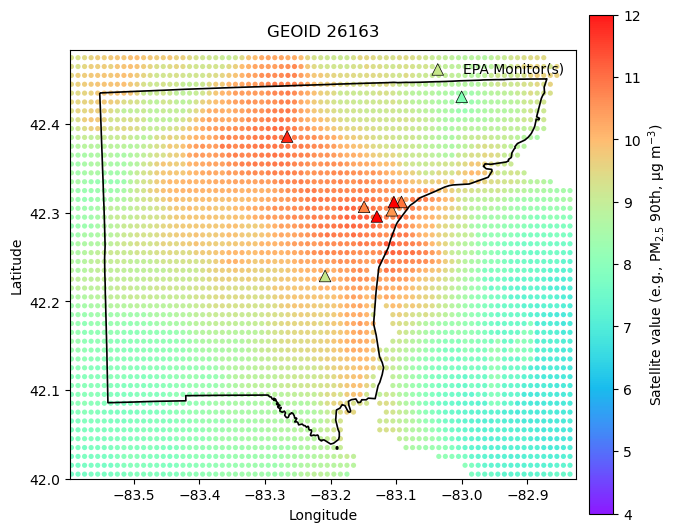

22051
8.2
here


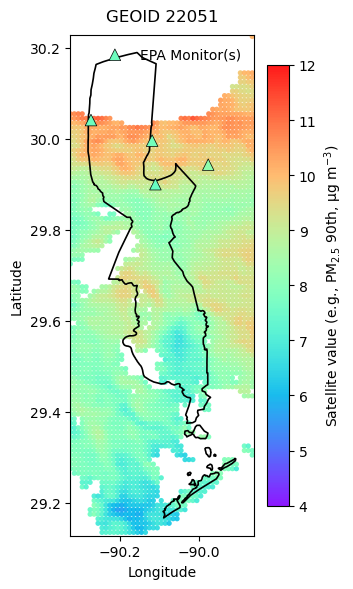

39035
12.2
here


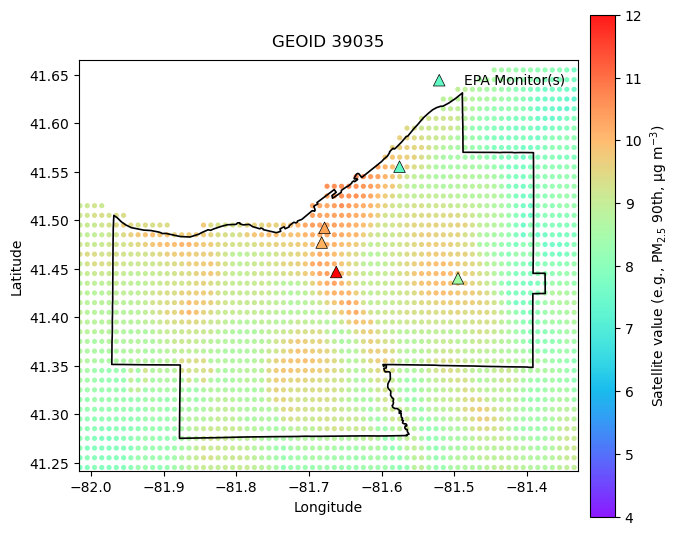

12103
6.9
here


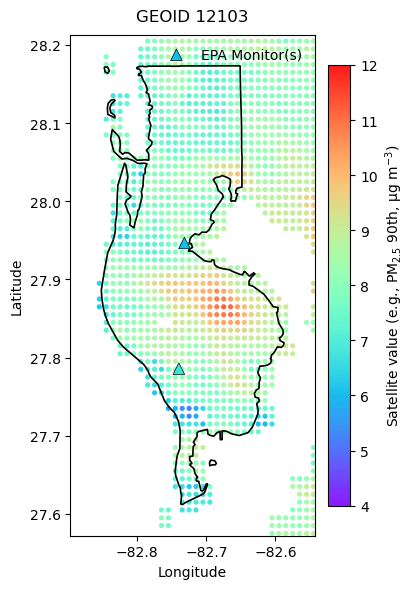

12117
6.5
here


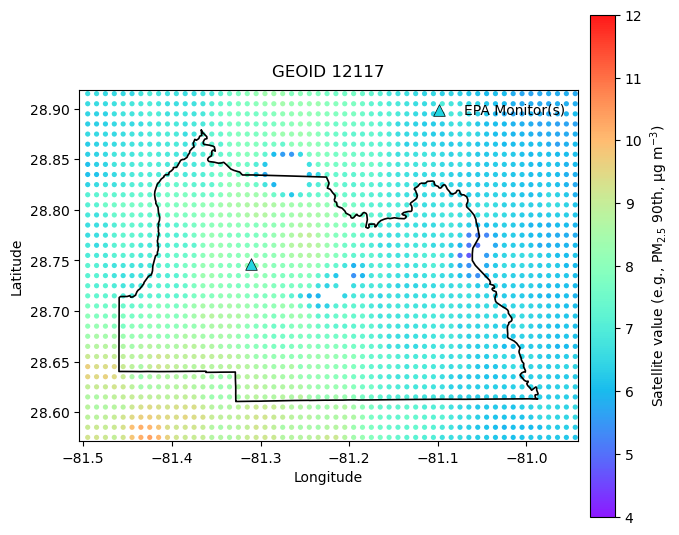

24029
7.3
here


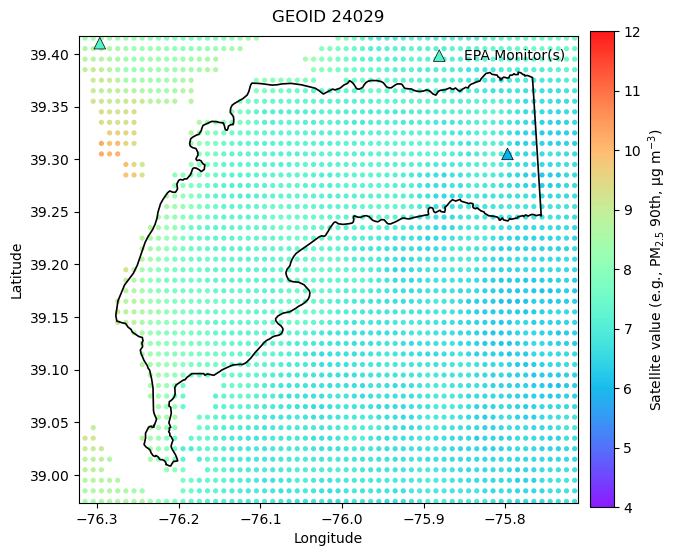

44003
4.9
here


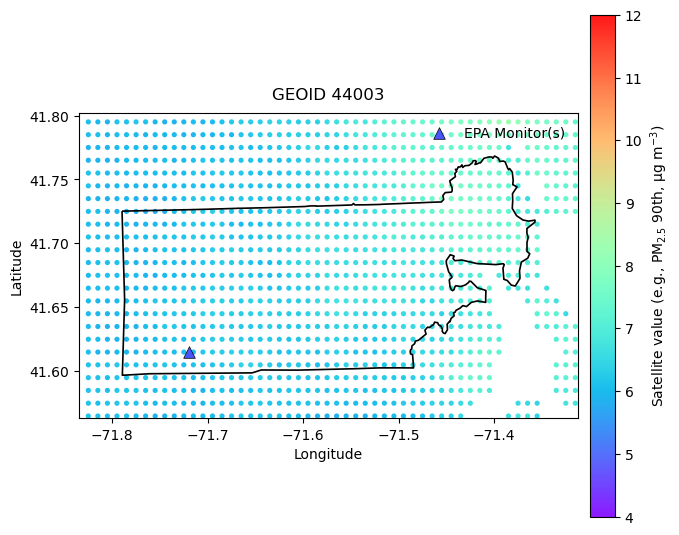

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

# ----------------------------
# CONFIG: color scale across all counties (global min/max)
# ----------------------------
global_vmin = 4   # lower for satellite values
global_vmax = 12   # upper for satellite values

def county_bbox_with_buffer(geom, buffer_km=5):
    """Return (minx, maxx, miny, maxy) in EPSG:4326 with ~buffer_km padding."""
    g = gpd.GeoSeries([geom], crs="EPSG:4269").to_crs(3857)
    g_buf = g.buffer(buffer_km * 1000)  # meters
    g_buf_ll = g_buf.to_crs(4326)
    minx, miny, maxx, maxy = g_buf_ll.total_bounds
    return minx, maxx, miny, maxy

def plot_county_overlay(
    geoid,
    counties_gdf,        # GeoDF with GEOID + geometry (EPSG:4269)
    monitors_gdf,        # GeoDF of monitor points (has 'Valid DV') (EPSG:4269 or any; reprojected to 4326 below)
    sat_df,              # DataFrame with columns: lon, lat, value (already in 4326 lon/lat)
    meta_df=None,        # OPTIONAL DF with GEOID + metadata for title
    save_dir=None,
    label_monitors=True,
    size_by_dv=True
):
    # Find county row
    row = counties_gdf.loc[counties_gdf['GEOID'].astype(str) == str(geoid)]
    if row.empty:
        print(f"GEOID {geoid}: county not found in counties_gdf")
        return
    county_geom = row.iloc[0].geometry

    # Bbox
    minx, maxx, miny, maxy = county_bbox_with_buffer(county_geom, buffer_km=5)

    # Subset satellite by bbox (no clipping)
    sat_sel = sat_df[(sat_df['lon'] >= minx) & (sat_df['lon'] <= maxx) &
                     (sat_df['lat'] >= miny) & (sat_df['lat'] <= maxy)]

    # Reproject monitors to 4326 if needed, then bbox filter
    mons = monitors_gdf.to_crs(4326) if getattr(monitors_gdf, "crs", None) is not None else monitors_gdf
    mon_sel = monitors_gdf[(monitors_gdf['Site Longitude'] >= minx) &
                           (monitors_gdf['Site Longitude'] <= maxx) &
                           (monitors_gdf['Site Latitude'] >= miny) &
                           (monitors_gdf['Site Latitude'] <= maxy)].copy()

    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))

    # Satellite grid scatter
    sc = ax.scatter(
        sat_sel['lon'], sat_sel['lat'],
        c=sat_sel['value'],
        s=14, cmap='rainbow',
        vmin=global_vmin, vmax=global_vmax,
        alpha=0.9, linewidths=0
    )

    # County outline
    gpd.GeoSeries([county_geom], crs="EPSG:4269").to_crs(4326).plot(
        ax=ax, facecolor='none', edgecolor='k', linewidth=1.2
    )
    
    print(mon_sel['Valid DV '].max())
    if not mon_sel.empty:
        print('here')
        ax.scatter(
            mon_sel['Site Longitude'], mon_sel['Site Latitude'],
            c=mon_sel['Valid DV '],
            s=70, cmap='rainbow',
            vmin=global_vmin, vmax=global_vmax,
            edgecolors='black', linewidths=0.5,
            marker='^', label='EPA Monitor(s)'
        )


    # Axes & colorbar
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    title_suffix = ""
    if (meta_df is not None) and ('GEOID' in meta_df.columns):
        meta_row = meta_df.loc[meta_df['GEOID'].astype(str) == str(geoid)]
        if not meta_row.empty:
            r = meta_row.iloc[0]
            cls = r.get('classification', '')
            ad  = r.get('abs_diff', np.nan)
            title_suffix = f" | class={cls}"
            if pd.notna(ad):
                title_suffix += f" | |CDVE−CDV|={ad:.2f}"
    ax.set_title(f"GEOID {geoid}{title_suffix}", pad=10)

    cb = plt.colorbar(sc, ax=ax, pad=0.02, shrink=0.88)
    cb.set_label("Satellite value (e.g., PM$_{2.5}$ 90th, µg m$^{-3}$)")

    if not mon_sel.empty:
        ax.legend(frameon=False, loc='upper right')

    plt.tight_layout()
    if save_dir:
        plt.savefig(f"{save_dir}/overlay_{geoid}.png", dpi=300)
    plt.show()

# ----------------------------
# RUN FOR ALL OUTLIERS
# ----------------------------
geoid_list = outliers_iqr['GEOID'].astype(str).tolist()
for g in geoid_list:
    print(g)
    plot_county_overlay(
        geoid=g,
        counties_gdf=outliers_iqr,   # has GEOID + geometry (EPSG:4269)
        monitors_gdf=valid,          # monitor points with 'Valid DV'
        sat_df=df,                   # lon, lat, value (value = satellite metric)
        meta_df=None,                # or pass your county metrics DF that HAS GEOID
        save_dir=None,
        label_monitors=True,
        size_by_dv=True
    )
